In [27]:
#https://gorelick.medium.com/fast-er-downloads-a2abd512aa26

import ee
import requests
import os
import shutil
import tqdm.notebook as tqdm

  
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com',project='ee-seasonal-snow-cover')


In [28]:
import rioxarray as rio
import pyproj 
popgrid = rio.open_rasterio('pop2021.tif',band_as_variable=True).band_1
crs='EPSG:3035' #popgrid.rio.crs
transformer = pyproj.transformer.Transformer.from_crs(crs,"epsg:4326", always_xy=True)

In [ ]:
import numpy as np
np.random.seed(0)
N=30
Nlarge=100000
x = np.random.randint(0, popgrid.shape[1], Nlarge)
y = np.random.randint(0, popgrid.shape[0], Nlarge)

p = popgrid.data[y,x]
ix = np.where(p>2000)[0]
ix = ix[:N]

#p=p[y[ix],x[ix]]
x=popgrid.x.data[x[ix]]
y=popgrid.y.data[y[ix]]
p = p[ix]

points = [[float(x),float(y),int(p)] for x,y,p in zip(x,y,p)]


30

In [ ]:
y,x = np.meshgrid(range(popgrid.shape[0]),range(popgrid.shape[1]))
x = x.flatten()
y = y.flatten()
ix = np.where(popgrid.data.flatten()>0)[0]
cump = np.cumsum(popgrid.data.flatten()[ix])
x = x[ix]
y = y[ix]
person = np.random.rand(10)*cump[-1]
ix = np.ceil(np.interp(person,p,np.arange(len(cump)))).astype(int)

x=popgrid.x.data[x[ix]]
y=popgrid.y.data[y[ix]]
p = cump[ix]
points = [[float(x),float(y),int(p)] for x,y,p in zip(x.tolist(),y.tolist(),p.tolist())]
points

[[6609500.0, 1298500.0, 350931944],
 [6409500.0, 3740500.0, 298702765],
 [6508500.0, -2757500.0, 321815296],
 [6349500.0, -1383500.0, 286290695],
 [6512500.0, 1892500.0, 323391060],
 [6716500.0, 4404500.0, 371684708],
 [6515500.0, 2116500.0, 324608625],
 [6784500.0, 4751500.0, 387229959],
 [7155500.0, 2907500.0, 422235338],
 [7754500.0, 3773500.0, 439086872]]

In [63]:
from retry import retry

folder=os.path.abspath('tiles/')

#@retry(tries=10, delay=1, backoff=2)
def getResult(index, point):
  
  """Handle the HTTP requests to download an image."""

  # Generate the desired image from the given point.
  #filename = f'{folder}/{point[0]/1000:.0f}_{point[1]/1000:.0f}_pop{point[2]:.0f}.tif'

  pixelsize = 20 #meter
  tilewidth = 5000 #meter
  point[0] = np.floor(point[0]/tilewidth)*tilewidth
  point[1] = np.floor(point[1]/tilewidth)*tilewidth
  filename = f'{folder}/{int(tilewidth/1000)}km_{int(point[0]/1000)}_{int(point[1]/1000)}.tif'
  if os.path.exists(filename):
    print("Already exists: ", filename)
    return
  
  Npixels = int(tilewidth/pixelsize)
  corner_w = point[0] # + pixelsize/2
  corner_s = point[1] # + pixelsize/2
  corner_e = corner_w + tilewidth #- pixelsize
  corner_n = corner_s + tilewidth #- pixelsize
  region = ee.Geometry.Rectangle([
    ee.Geometry.Point((corner_w, corner_s),proj=crs),  
    ee.Geometry.Point((corner_e, corner_n),proj=crs)
  ], proj=crs, evenOdd=False)
  
  image = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') #('LANDSAT/LC08/C02/T1')
           .filterBounds(region)
           .filterDate('2019', '2023') #more years to get more stable stats
           .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20))
           .filter(ee.Filter.calendarRange(6,10,'month')) #get rid of snowy season (and reduce memory usage)
           .median()
           .select('B1','B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12')
           )

  s1vv = (ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterDate('2021', '2022')
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
    .select(['VV'])
    .median())

  s1vh = (ee.ImageCollection('COPERNICUS/S1_GRD')
    .filterDate('2021', '2022')
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH'))
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
    .select(['VH'])
    .median())

  nightlight = (ee.ImageCollection('NASA/VIIRS/002/VNP46A2')
    .filterDate('2021', '2022')
    .select('DNB_BRDF_Corrected_NTL')
    .median())

  image = image.addBands([nightlight,s1vv,s1vh])

  # Fetch the URL from which to download the image.
  url = image.clip(region).getDownloadURL({
      'region': region,
      'crs':crs,
      'dimensions': f'{Npixels}x{Npixels}',
      'format': 'GEO_TIFF'})

  # Handle downloading the actual pixels.
  r = requests.get(url, stream=True)
  if r.status_code != 200:
    print("Error: ", index, point, r.text)
    raise r.raise_for_status()

  with open(filename, 'wb') as out_file:
    shutil.copyfileobj(r.raw, out_file)
  print("Done: ", index, filename) 

In [64]:
getResult(0, points[0])

Done:  0 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_6605_1295.tif


In [ ]:
for j in tqdm.tqdm(range(len(points))): #optional:use multiprocessing instead
    getResult(j, points[j])

  0%|          | 0/10 [00:00<?, ?it/s]

Already exists:  c:\Users\ag\Documents\Python\pop_europe\tiles/5km_6605_1295.tif
Done:  1 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_6405_3740.tif
Done:  2 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_6505_-2760.tif
Done:  3 c:\Users\ag\Documents\Python\pop_europe\tiles/5km_6345_-1385.tif


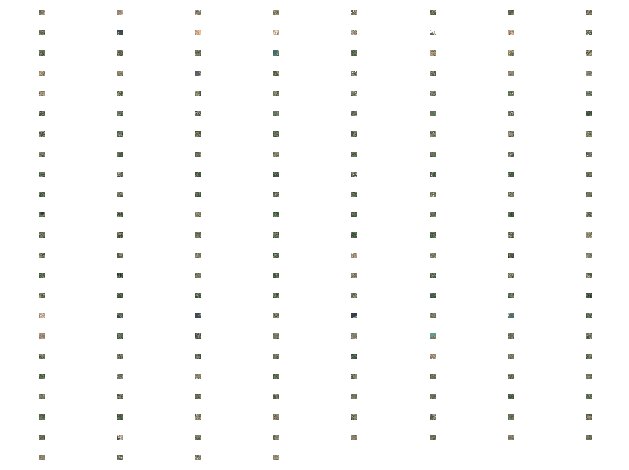

In [37]:
import glob
import matplotlib.pyplot as plt
files=glob.glob('tiles/*.tif')
for ix,file in enumerate(files):
    plt.subplot(int(len(files)/8+.99),8,ix+1)
    ds = rio.open_rasterio(file)
    np.sqrt(np.minimum(ds[3:0:-1,:,:]/3500,1)).plot.imshow()
    plt.axis('off')
    plt.axis('equal')
    plt.title('')
    #1/0
plt.tight_layout()

np.int64(355818029)

In [ ]:


y,x = np.meshgrid(range(popgrid.shape[0]),range(popgrid.shape[1]))
x = x.flatten()
y = y.flatten()
ix = np.where(popgrid.data.flatten()>0)[0]
p = np.cumsum(popgrid.data.flatten()[ix])
x = x[ix]
y = y[ix]
person = np.random.rand(10)*p[-1]
ix = np.ceil(np.interp(person,p,np.arange(len(p)))).astype(int)


(np.int64(4208), np.int64(7131))

In [57]:
points[0]

[np.float64(4940000.0), np.float64(3060000.0), 4073]

In [60]:
p.tolist()

202169249

In [61]:
x,y,p

(np.float64(5968500.0), np.float64(-2684500.0), np.int64(202169249))